# Logistic Regression and kNN classifiers

Very simple example to show:
- Feature selection manually and using random forrest classifier
- Statistical analysis of input data
- kNN and Logistic Regression classifiers
- Confusion matrix, ROC

The goal is to predict if a student would have jobs after the graduation.

## Loading libraries

In [1]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, plot_confusion_matrix
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve, precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
%matplotlib inline

## Loading the data

In [2]:
df = pd.read_csv("./data/placementData.csv")
df.head()

,sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,1,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed,270000.0
1,2,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed,200000.0
2,3,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed,250000.0
3,4,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed,NaN
4,5,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed,425000.0


## Data exploration

In [3]:
df.describe()

,sl_no,ssc_p,hsc_p,degree_p,etest_p,mba_p,salary
count,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,148.000000
mean,108.000000,67.303395,66.333163,66.370186,72.100558,62.278186,288655.405405
std,62.209324,10.827205,10.897509,7.358743,13.275956,5.833385,93457.452420
min,1.000000,40.890000,37.000000,50.000000,50.000000,51.210000,200000.000000
25%,54.500000,60.600000,60.900000,61.000000,60.000000,57.945000,240000.000000
50%,108.000000,67.000000,65.000000,66.000000,71.000000,62.000000,265000.000000
75%,161.500000,75.700000,73.000000,72.000000,83.500000,66.255000,300000.000000
max,215.000000,89.400000,97.700000,91.000000,98.000000,77.890000,940000.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sl_no           215 non-null    int64  
 1   gender          215 non-null    object 
 2   ssc_p           215 non-null    float64
 3   ssc_b           215 non-null    object 
 4   hsc_p           215 non-null    float64
 5   hsc_b           215 non-null    object 
 6   hsc_s           215 non-null    object 
 7   degree_p        215 non-null    float64
 8   degree_t        215 non-null    object 
 9   workex          215 non-null    object 
 10  etest_p         215 non-null    float64
 11  specialisation  215 non-null    object 
 12  mba_p           215 non-null    float64
 13  status          215 non-null    object 
 14  salary          148 non-null    float64
dtypes: float64(6), int64(1), object(8)
memory usage: 25.3+ KB


Looking at the data sl_no cannot be a predictor as it is simply an index for student. Also salary is a direct indicator if the person has job. So will drop these two columns/features.

Our data size is small so it is better to use simpler models.

In [5]:
df = df.drop(['sl_no', 'salary'], axis=1)
df.head()

,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status
0,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed
1,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed
2,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed
3,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed
4,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed


# Feature Selection

We want to select the features that show impact on the target based on our data exploration. We can go over different features and check the distribution of the target(status) over them.

First we check categorical features.

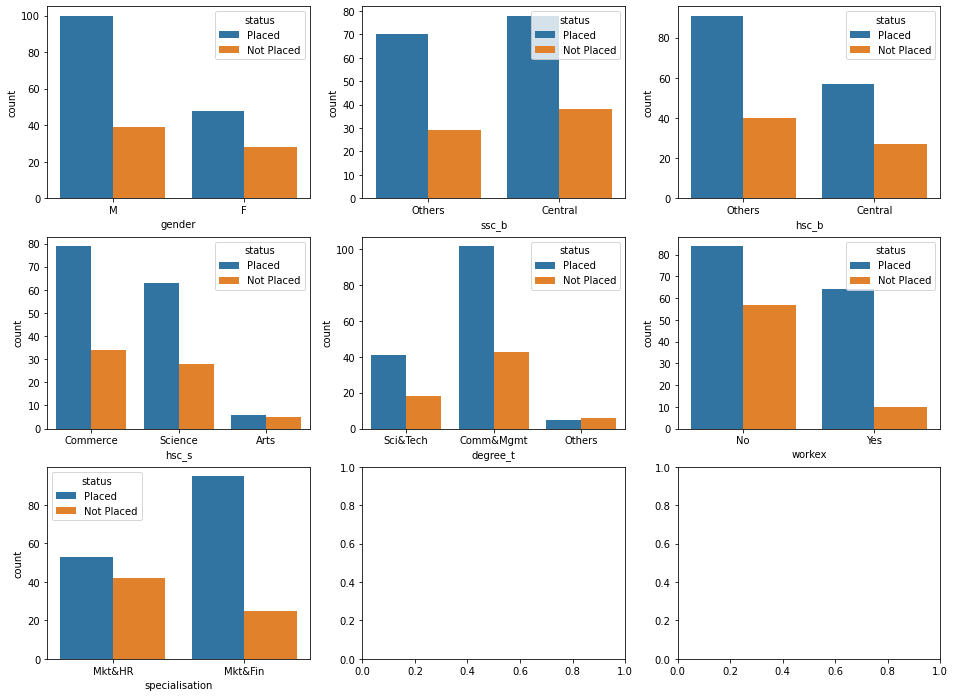

In [6]:
cat_features = ['gender', 'ssc_b', 'hsc_b', 'hsc_s', 'degree_t', 'workex', 'specialisation']

fig, ax = plt.subplots(3, 3, figsize=(16, 12))
for i in range(7):
    sns.countplot(ax = ax[i // 3, i % 3], x = cat_features[i], hue='status', data=df)    

It seems that ssc_b and hsc_b have no effect on the target (status), so we will not use them as features.

Next, we check the numerical features:

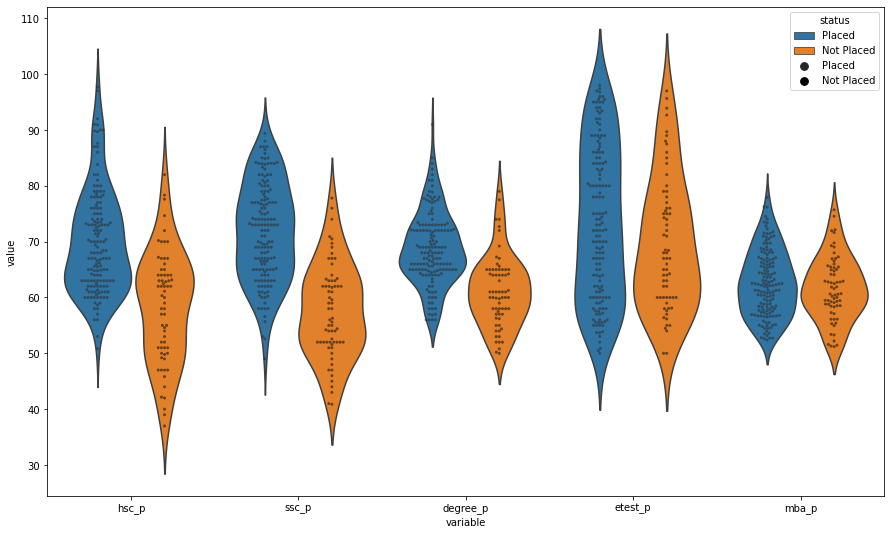

In [7]:
numerical_df = df[['hsc_p', 'ssc_p', 'degree_p', 'etest_p', 'mba_p', 'status']]
plt.figure(figsize=(15,9))
sns.violinplot(x="variable", y="value", hue="status", inner=None, data=pd.melt(numerical_df, id_vars=['status']))
sns.swarmplot(x="variable", y="value", hue="status", dodge=True, color='k', alpha=0.5, size=3, 
              data=pd.melt(numerical_df, id_vars=['status']));

Now, it seems that etest_p and mba_p have no differetial impact on the target. So, we will not include them as features either. 

So with exploring the categorical and numerical features we drop 4 out of the toal 12 features and have 8 features remaining. With this we can define the data and labels:


In [8]:
X_ = df[['gender', 'ssc_p', 'hsc_p', 'hsc_s', 'degree_p', 'degree_t', 'workex','specialisation']]
y = df['status']

# Feature Selection using random forrest

We selected the features manually. We can compare our selected features by feature score received by traing a random forrest classifier.

We can add a column to the data with random numbers and select the features/columns that score higher than this random feature.

In [9]:
# Selected all possible relevant features
XX = df[['gender', 'ssc_p', 'ssc_b', 'hsc_p', 'hsc_b', 'hsc_s', 'degree_p', 'degree_t', 'workex', 'etest_p', 'specialisation', 
        'mba_p']]

# Add a random feature - we can pick the ones that are scored higher
XX['rand'] = np.random.randint(1, 3, XX.shape[0])

#Changing the categorical variables into one-hot
XX = pd.get_dummies(XX)

In [10]:
XX.head()

,ssc_p,hsc_p,degree_p,etest_p,mba_p,rand,gender_F,gender_M,ssc_b_Central,ssc_b_Others,...,hsc_s_Arts,hsc_s_Commerce,hsc_s_Science,degree_t_Comm&Mgmt,degree_t_Others,degree_t_Sci&Tech,workex_No,workex_Yes,specialisation_Mkt&Fin,specialisation_Mkt&HR
0,67.00,91.00,58.00,55.0,58.80,2,0,1,0,1,...,0,1,0,0,0,1,1,0,0,1
1,79.33,78.33,77.48,86.5,66.28,1,0,1,1,0,...,0,0,1,0,0,1,0,1,1,0
2,65.00,68.00,64.00,75.0,57.80,1,0,1,1,0,...,1,0,0,1,0,0,1,0,1,0
3,56.00,52.00,52.00,66.0,59.43,1,0,1,1,0,...,0,0,1,0,0,1,1,0,0,1
4,85.80,73.60,73.30,96.8,55.50,1,0,1,1,0,...,0,1,0,1,0,0,1,0,1,0


In [11]:
forest = RandomForestClassifier(n_estimators = 200);
forest.fit(XX, y)

RandomForestClassifier(n_estimators=200)

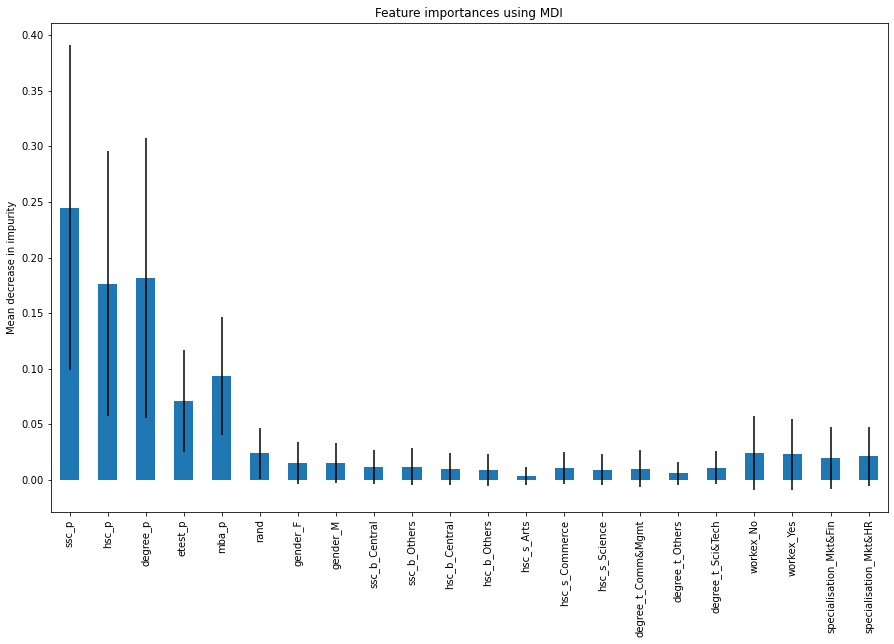

In [12]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

plt.figure(figsize=(15,9))

forest_importances = pd.Series(importances, index = XX.columns)
forest_importances.plot.bar(yerr = std)
plt.title("Feature importances using MDI")
plt.ylabel("Mean decrease in impurity")
fig.tight_layout()

We get more or less the same result. One issues is that for this to work better, it was better to simply transform categorical labels to numerical labels instead of splitting them into one-hot features. But we continue with our manually engineered features.

# Data preprocessing

Looking at the X_ dataframe we need to replace the selected categorical values with some numerical representation. One of the best ways is to translate them into their one hot encoding. For example for gender that there are two options of 0 and 1, this will be translated to two features, one with gender_M == 1 if gender equals M and one with gender_F == 1 only if gender equals F.

In [13]:
X_.head()

,gender,ssc_p,hsc_p,hsc_s,degree_p,degree_t,workex,specialisation
0,M,67.00,91.00,Commerce,58.00,Sci&Tech,No,Mkt&HR
1,M,79.33,78.33,Science,77.48,Sci&Tech,Yes,Mkt&Fin
2,M,65.00,68.00,Arts,64.00,Comm&Mgmt,No,Mkt&Fin
3,M,56.00,52.00,Science,52.00,Sci&Tech,No,Mkt&HR
4,M,85.80,73.60,Commerce,73.30,Comm&Mgmt,No,Mkt&Fin


Translation from categorical values to one-hot encoding can be done by using [pd.get_dummies](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html)

In [14]:
X = pd.get_dummies(X_)
X.head()

,ssc_p,hsc_p,degree_p,gender_F,gender_M,hsc_s_Arts,hsc_s_Commerce,hsc_s_Science,degree_t_Comm&Mgmt,degree_t_Others,degree_t_Sci&Tech,workex_No,workex_Yes,specialisation_Mkt&Fin,specialisation_Mkt&HR
0,67.00,91.00,58.00,0,1,0,1,0,0,0,1,1,0,0,1
1,79.33,78.33,77.48,0,1,0,0,1,0,0,1,0,1,1,0
2,65.00,68.00,64.00,0,1,1,0,0,1,0,0,1,0,1,0
3,56.00,52.00,52.00,0,1,0,0,1,0,0,1,1,0,0,1
4,85.80,73.60,73.30,0,1,0,1,0,1,0,0,1,0,1,0


For the models to perform good, we need to scale/normalize the inputs now that all the values are numerical.

In [15]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

Next we split the data between train and test sets:

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=100)

## Logistic Regression Model

We use sklearn to fit the train data into a logistic regression model.
Then we pass the test data to it to get the predictions on test data.

In [17]:
LR = LogisticRegression()
LR.fit(X_train, y_train)
y_pred_LR = LR.predict(X_test)

## kNN Model

Similary we fot the train data to a kNN classifier model.

In [18]:
kNN = KNeighborsClassifier(n_neighbors=5)
kNN.fit(X_train, y_train)
y_pred_kNN = kNN.predict(X_test)

# Model Evaluation

We will evaluate: 
- Precision, Recall, F1-score
- Precision vs. Recall curve
- Confusion matrix
- ROC curve


In [19]:
print("Logistic Regression Model:")
print(classification_report(y_test, y_pred_LR))

print("kNN Model:")
print(classification_report(y_test, y_pred_kNN))

Logistic Regression Model:
              precision    recall  f1-score   support

  Not Placed       0.86      0.71      0.77        17
      Placed       0.83      0.92      0.87        26

    accuracy                           0.84        43
   macro avg       0.84      0.81      0.82        43
weighted avg       0.84      0.84      0.83        43

kNN Model:
              precision    recall  f1-score   support

  Not Placed       0.62      0.47      0.53        17
      Placed       0.70      0.81      0.75        26

    accuracy                           0.67        43
   macro avg       0.66      0.64      0.64        43
weighted avg       0.67      0.67      0.66        43



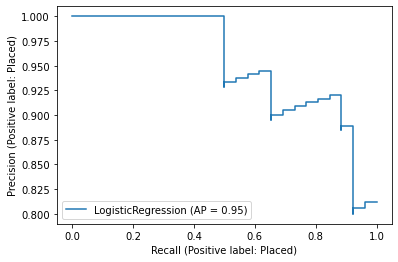

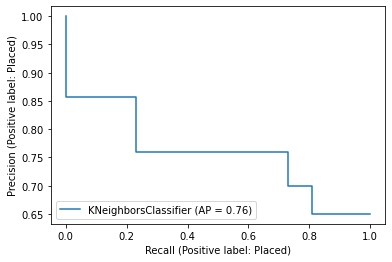

In [20]:
plot_precision_recall_curve(LR, X_test, y_test)
plot_precision_recall_curve(kNN, X_test, y_test)

Logistic Regression Model:


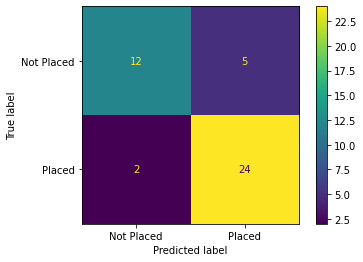

kNN Model:


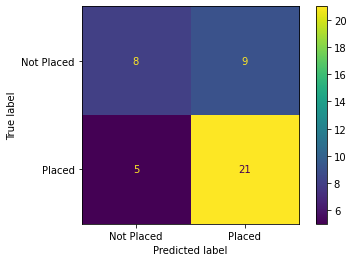

In [21]:
print("Logistic Regression Model:")
plot_confusion_matrix(LR, X_test, y_test)
plt.show()

print("kNN Model:")
plot_confusion_matrix(kNN, X_test, y_test)
plt.show()

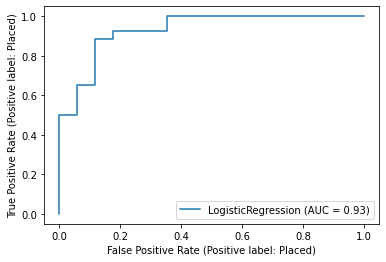

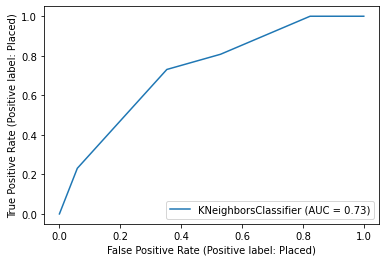

In [22]:
plot_roc_curve(LR, X_test, y_test);
plot_roc_curve(kNN, X_test, y_test);

## Regularization

We can try different regularization levels on the models as hyperparameters and sweep them and select the best parameters based on for example f1-score on the validation set.

For logistic regression it is input to sklearn model as parameter C. For kNN it is in principle the number of neighbours k.

In [23]:
C = [0.2, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 5.0]
print("Logistic Regression:")
for c in C:
    model = LogisticRegression(C = c, max_iter = 100, tol = 1e-6)
    model.fit(X_train, y_train)
    ypred = model.predict( X_test )
    p, r, f, s = precision_recall_fscore_support( y_test, ypred, average='micro')
    print("c: %.2f - f1: %.4f" %(c, f))

print("============")


#Regularize by searching for different number of neighbors
N = [1, 2, 3, 4, 5, 6]
print("kNN")
for n in N:
    neigh = KNeighborsClassifier(n_neighbors=n)
    neigh.fit(X_train, y_train)
    ypred = neigh.predict(X_test)

    p, r, f, s = precision_recall_fscore_support( y_test, ypred, average='micro')
    print("n: %d - f1: %.4f" %(n, f))

print("===========")

Logistic Regression:
c: 0.20 - f1: 0.7674
c: 0.50 - f1: 0.8372
c: 1.00 - f1: 0.8372
c: 1.50 - f1: 0.8372
c: 2.00 - f1: 0.8605
c: 2.50 - f1: 0.8605
c: 3.00 - f1: 0.8605
c: 5.00 - f1: 0.8605
kNN
n: 1 - f1: 0.7442
n: 2 - f1: 0.6512
n: 3 - f1: 0.7674
n: 4 - f1: 0.7209
n: 5 - f1: 0.6744
n: 6 - f1: 0.6744
